In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [2]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.26.4
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


#### 모델 저장

In [5]:
def saveModel():
    torch.save(model.state_dict(), 'model_lstmautoencoder_ar1_latentvector.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [6]:
# 하이퍼파라미터 설정
length = 12            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 250       # 생성할 학습 데이터 시퀀스의 수 
validrun = 125         # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi값을 0.25, 0.5, 0.75, 0.95별로 생성)
phi1 = np.array([0.25, 0.5, 0.75, 0.95])

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [7]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def ar(ar1, delta, gamma, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt(1 / (1 - pow(ar1, 2)))                    # AR(1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.zeros(length)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)
        
        for t in range(1, length):
            x[t] = ar1 * x[t - 1] + e[t]                        # 관리상태 시계열 데이터 생성
                               
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, phi in enumerate(phi1):
        y[i]= ar(phi, de1, ga, length, run)

    return y.reshape(run * len(phi1), length)                   # 생성된 데이터를 적절한 형태로 재배열


In [8]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                 # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [9]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [10]:
len(trainloader)

1000

In [11]:
len(validloader)

500

In [12]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Encoder 클래스 정의
class Encoder(nn.Module):
    def __init__(self, seq_length, latent_dim, input_dim):
        super(Encoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=latent_dim, num_layers=1, batch_first=True)
        self.seq_length = seq_length

    def forward(self, x):
        x, _ = self.lstm1(x)
        z, _ = self.lstm2(x)
        z_rep = z.unsqueeze(1).repeat(1, self.seq_length, 1)  # (batch_size, seq_length, latent_dim)
        return z, z_rep

# Decoder 클래스 정의
class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Decoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=latent_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.time_distributed = nn.Linear(128, input_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.time_distributed(x)
        return x

# 전체 LSTM 오토인코더 모델 정의
class LstmAE(nn.Module):
    def __init__(self, seq_length, input_dim, latent_dim):
        super(LstmAE, self).__init__()
        self.encoder = Encoder(seq_length, latent_dim, input_dim)
        self.decoder = Decoder(input_dim, latent_dim)

    def forward(self, x):
        z, z_rep = self.encoder(x)
        decoded = self.decoder(z_rep)
        return decoded

# 모델 인스턴스 생성 및 설정
seq_length = 12  #  시퀀스 길이
input_dim = 12   #  입력 차원
latent_dim = 1   # 잠재 차원

# 모델 인스턴스 생성 및 설정
model = LstmAE(seq_length=seq_length, input_dim=input_dim, latent_dim=latent_dim)
model = model.to(device)

/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1, 12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 2.1815, Validation Loss: 2.2395
Validation loss decreased (inf --> 2.239472).  Saving model ...
Epoch 2, Train Loss: 2.1814, Validation Loss: 2.2394
Validation loss decreased (2.239472 --> 2.239361).  Saving model ...
Epoch 3, Train Loss: 2.1812, Validation Loss: 2.2393
Validation loss decreased (2.239361 --> 2.239250).  Saving model ...
Epoch 4, Train Loss: 2.1810, Validation Loss: 2.2391
Validation loss decreased (2.239250 --> 2.239134).  Saving model ...
Epoch 5, Train Loss: 2.1808, Validation Loss: 2.2390
Validation loss decreased (2.239134 --> 2.239024).  Saving model ...
Epoch 6, Train Loss: 2.1806, Validation Loss: 2.2389
Validation loss decreased (2.239024 --> 2.238915).  Saving model ...
Epoch 7, Train Loss: 2.1804, Validation Loss: 2.2388
Validation loss decreased (2.238915 --> 2.238804).  Saving model ...
Epoch 8, Train Loss: 2.1802, Validation Loss: 2.2387
Validation loss decreased (2.238804 --> 2.238692).  Saving model ...
Epoch 9, Train Loss: 2.1800, 

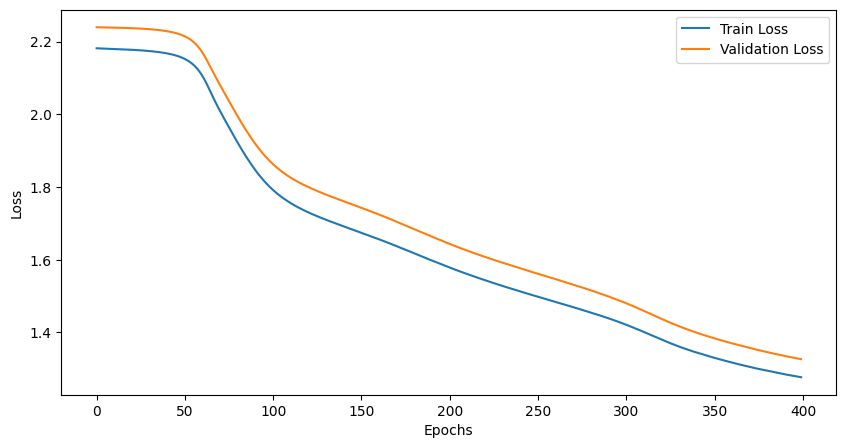

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
def training(epochs):
    loss_ = []
    valoss_ = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # Training process
        for data in trainloader:
            model.train()
            inputs = data                                                           # Assuming data is the input tensor
            inputs = inputs.to(device)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, inputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)
        
        # Validation process
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Save model
    saveModel()
    return loss_, valoss_  # Return the collected loss values for training and validation

# Now when you call training, it will return the lists to be unpacked.
loss_, valoss_ = training(epochs=400)  # Set the appropriate number of epochs

# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 모델 불러오기

In [71]:
model.load_state_dict(torch.load('model_lstmautoencoder_ar1_latentvector.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

#### 학습 데이터로부터 잠재 벡터 추출

In [72]:
latent_vectors = []
model.eval()
with torch.no_grad():
    for data in trainloader:
        inputs = data.to(device)
        latent_vec, _ = model.encoder(inputs)
        latent_vectors.append(latent_vec.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
latent_vectors

array([[-0.03905151],
       [-0.21522114],
       [-0.14408895],
       [-0.21555002],
       [-0.18616465],
       [-0.14774205],
       [-0.2478122 ],
       [-0.16476046],
       [-0.17807911],
       [-0.08908682],
       [-0.14930595],
       [-0.7463238 ],
       [-0.373788  ],
       [-0.08643635],
       [-0.19607918],
       [-0.21473213],
       [-0.34341615],
       [-0.3359558 ],
       [-0.49723342],
       [-0.15046379],
       [-0.09192927],
       [-0.36499196],
       [-0.16591214],
       [-0.24705045],
       [-0.66556066],
       [-0.21210617],
       [-0.14760819],
       [-0.26981685],
       [-0.22698437],
       [-0.17388743],
       [-0.24433777],
       [-0.1682092 ],
       [-0.10611787],
       [-0.1587387 ],
       [-0.1595495 ],
       [-0.20380412],
       [-0.18049629],
       [-0.1389076 ],
       [-0.27257958],
       [-0.23294032],
       [-0.21710691],
       [-0.4796555 ],
       [-0.14247867],
       [-0.35806733],
       [-0.15534136],
       [-0

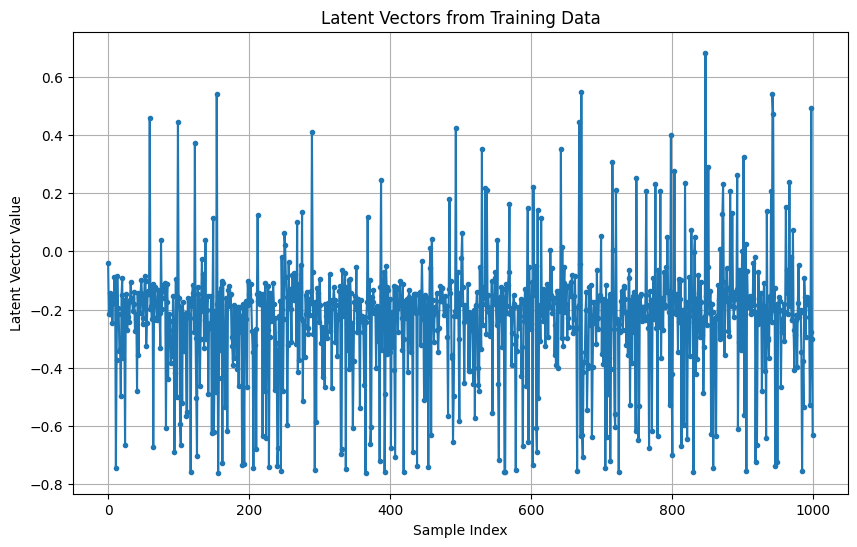

In [73]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### 학습 데이터로부터 잠재 벡터의 평균 계산

In [74]:
mean_latent_vector = np.mean(latent_vectors)
mean_latent_vector

-0.23215054

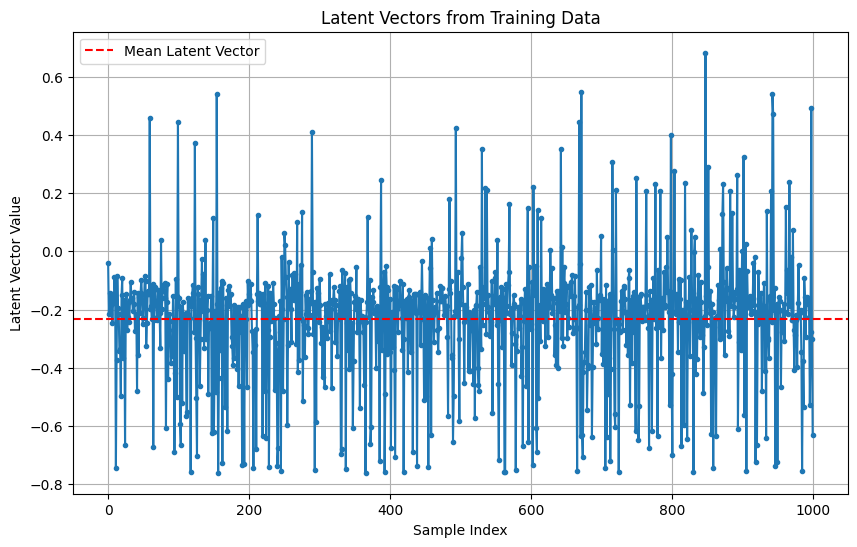

In [75]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.axhline(y=mean_latent_vector, color='r', linestyle='--', label='Mean Latent Vector')
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
centering_mean = np.abs(latent_vectors - mean_latent_vector)
centering_mean

array([[1.93099022e-01],
       [1.69294029e-02],
       [8.80615860e-02],
       [1.66005194e-02],
       [4.59858924e-02],
       [8.44084918e-02],
       [1.56616569e-02],
       [6.73900843e-02],
       [5.40714264e-02],
       [1.43063724e-01],
       [8.28445852e-02],
       [5.14173269e-01],
       [1.41637459e-01],
       [1.45714194e-01],
       [3.60713601e-02],
       [1.74184144e-02],
       [1.11265615e-01],
       [1.03805259e-01],
       [2.65082896e-01],
       [8.16867501e-02],
       [1.40221268e-01],
       [1.32841423e-01],
       [6.62384033e-02],
       [1.48999095e-02],
       [4.33410108e-01],
       [2.00443715e-02],
       [8.45423490e-02],
       [3.76663059e-02],
       [5.16617298e-03],
       [5.82631081e-02],
       [1.21872276e-02],
       [6.39413446e-02],
       [1.26032665e-01],
       [7.34118372e-02],
       [7.26010352e-02],
       [2.83464193e-02],
       [5.16542494e-02],
       [9.32429433e-02],
       [4.04290408e-02],
       [7.89776444e-04],


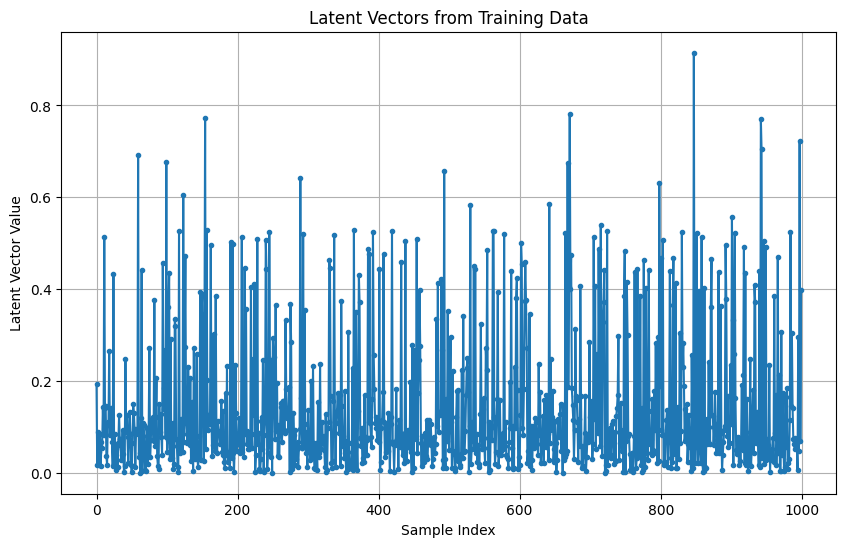

In [77]:
plt.figure(figsize=(10,6))
plt.plot(centering_mean, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### 학습 데이터로부터 잠재 벡터의 중앙값 계산

In [78]:
median_latent_vector = np.median(latent_vectors)
median_latent_vector

-0.20275944

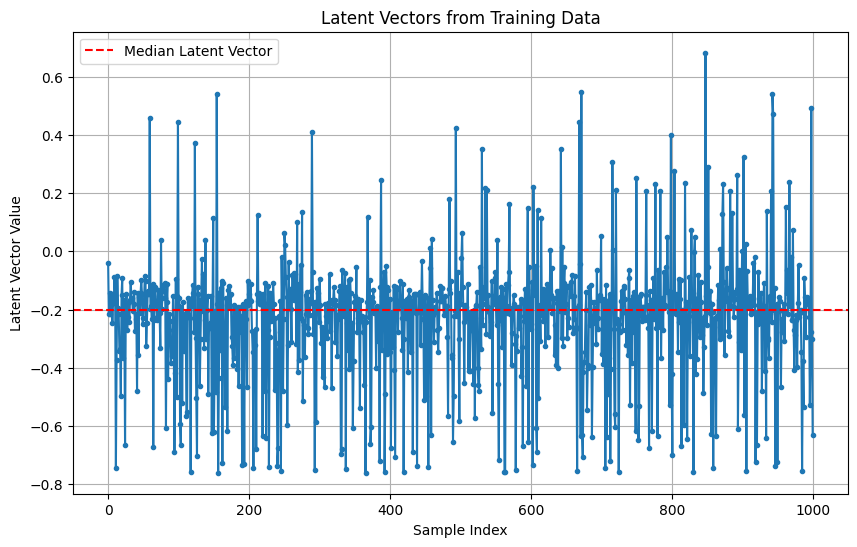

In [79]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.axhline(y=median_latent_vector, color='r', linestyle='--', label='Median Latent Vector')
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
centering_median = np.abs(latent_vectors - median_latent_vector)
centering_median

array([[1.63707927e-01],
       [1.24616921e-02],
       [5.86704910e-02],
       [1.27905756e-02],
       [1.65947974e-02],
       [5.50173968e-02],
       [4.50527519e-02],
       [3.79989892e-02],
       [2.46803313e-02],
       [1.13672629e-01],
       [5.34534901e-02],
       [5.43564379e-01],
       [1.71028554e-01],
       [1.16323091e-01],
       [6.68026507e-03],
       [1.19726807e-02],
       [1.40656710e-01],
       [1.33196354e-01],
       [2.94473976e-01],
       [5.22956550e-02],
       [1.10830173e-01],
       [1.62232518e-01],
       [3.68473083e-02],
       [4.42910045e-02],
       [4.62801218e-01],
       [9.34672356e-03],
       [5.51512539e-02],
       [6.70574009e-02],
       [2.42249221e-02],
       [2.88720131e-02],
       [4.15783226e-02],
       [3.45502496e-02],
       [9.66415703e-02],
       [4.40207422e-02],
       [4.32099402e-02],
       [1.04467571e-03],
       [2.22631544e-02],
       [6.38518482e-02],
       [6.98201358e-02],
       [3.01808715e-02],


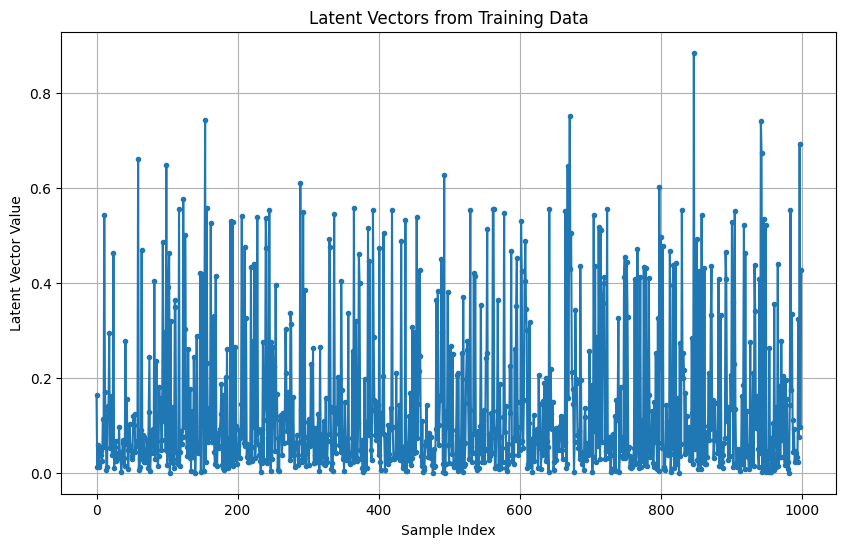

In [81]:
plt.figure(figsize=(10,6))
plt.plot(centering_median, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### ARL0 구하기

In [82]:
np.random.seed(1)

l = 12

# 관리상태 / 이상상태 데이터 생성 함수
def argen(ar, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt(1 / (1 - pow(ar, 2)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(0,len(x)):
        x[i] = ar * x[i - 1] + gamma*e[i]
        z[i] = x[i]
    for i in range(0,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [83]:
def arl(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = argen(ar=ar, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                latent_vec, _ = model.encoder(input)
                latent_vec_value = latent_vec.cpu().numpy()[0]

                if np.abs(latent_vec_value - median_latent_vector) > cl:
                    a = np.array([j + 1])
                    break
                elif j == len(x) - 1:
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl

#### ARL1 구하기

In [84]:
def arl1(ar,run,length,cl):
    a5 = arl(ar, 0.5, 1, run, length, cl)
    a1 = arl(ar, 1, 1, run, length, cl)
    a2 = arl(ar, 2, 1, run, length, cl)
    a3 = arl(ar, 3, 1, run, length, cl)
    b5 = arl(ar, 0.5, 1.5,run, length, cl)
    b1 = arl(ar, 1, 1.5, run, length, cl)
    b2 = arl(ar, 2, 1.5, run, length, cl)
    b3 = arl(ar, 3, 1, run, length, cl)
    c1 = arl(ar, 0, 1.5, run, length, cl)
    c2 = arl(ar, 0, 2, run, length, cl)
    c3 = arl(ar, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### Multi Processing

In [44]:
import multiprocessing
import numpy as np
from tqdm import tqdm
from multiprocessing import Process

def calculate_run_lengths(args):
    process_id, ar,delta, gamma, run, length, cl, result_queue, progress_queue = args
    # np.random.seed(seed_value + process_id)
    run_lengths = []
    for i in range(run):
        y = argen(ar=ar, delta=delta, gamma = gamma,length=length)
        print('a')
        a = np.array([length-l])
        print('b')
        x = np.zeros(shape=(length-l, l))
        print('c')
        for j in range(length-l):
            x[j] = y[j: j + l]
        print('d')
        x = torch.FloatTensor(x).to(device)
        print('e')

        model.eval()
        print('f')
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                latent_vec, _ = model.encoder(input)
                latent_vec_value = latent_vec.cpu().numpy()[0]

                if np.abs(latent_vec_value - median_latent_vector) > cl:
                    a = np.array([j + 1])
                    break
                elif j == len(x) - 1:
                    a = len(x)
            run_lengths.append(a)
        print('g')
        progress_queue.put(1)
        print('h\n')
    result_queue.put(run_lengths)


def calculate_run_lengths_multiprocessing(ar,delta,gamma, run, length, cl):
    num_processes = multiprocessing.cpu_count()
    print('1')
    result_queue = multiprocessing.Queue()
    print('2')
    progress_queue = multiprocessing.Queue()
    print('3')

    processes = []
    args_template = [(i, ar,delta,gamma, run // num_processes + (i < (run % num_processes)), length, cl, result_queue, progress_queue) for i in range(num_processes)]
    print('4')
    
    for i in range(num_processes):
        process = Process(target=calculate_run_lengths, args=(args_template[i],))  # 인자를 튜플로 묶어서 전달
        processes.append(process)
        process.start()
    print('5')
    
    # 진행 상태 표시줄 설정
    with tqdm(total=run) as pbar:
        for _ in range(run):
            pbar.update(progress_queue.get())
    print('6')
    
    all_run_lengths = []
    for i in range(num_processes):
        all_run_lengths.extend(result_queue.get())
    print('7')
    
    for process in processes:
        process.join()
    print('8')
    return all_run_lengths

if __name__ == '__main__':
    delta = de1
    gamma = ga
    run = 10000
    length = 1000
    cl = 0.4555
    run_lengths = calculate_run_lengths_multiprocessing(ar, delta, gamma, run, length, cl)
    print(np.mean(run_lengths))

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'calculate_run_lengths' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_pa

KeyboardInterrupt: 

#### phi = 0.25 일 때

##### ARL0 (threshold 임의추정)

In [33]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.4555)

100%|██████████| 1000/1000 [01:34<00:00, 10.59it/s]


987.634

In [34]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.4)

100%|██████████| 1000/1000 [01:33<00:00, 10.66it/s]


981.015

In [35]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.3)

100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


856.408

In [36]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.2)

100%|██████████| 1000/1000 [00:30<00:00, 32.87it/s]


308.452

In [37]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.23)

100%|██████████| 1000/1000 [00:48<00:00, 20.44it/s]


501.845

In [38]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.215)

100%|██████████| 1000/1000 [00:38<00:00, 25.81it/s]


399.241

In [39]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.213)

100%|██████████| 1000/1000 [00:38<00:00, 25.81it/s]


399.768

In [40]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.212)

100%|██████████| 1000/1000 [00:36<00:00, 27.50it/s]


376.68

In [41]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.212)

100%|██████████| 10000/10000 [06:05<00:00, 27.36it/s]


378.1814

##### ARL1

In [42]:
arl1(ar = 0.25, run = 10000, length = 1000, cl = 0.212)

100%|██████████| 10000/10000 [00:19<00:00, 517.26it/s]

0.5: 33.3405, 1:5.1126,2:1.0105,3:1.0
0.5:19.7854,1:6.0139,2:1.1693,3:1.0
1.5:71.3356,2:30.8174,3:13.4777


#### phi = 0.5 일 때

##### ARL0 (threshold 임의추정)

In [43]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.341)

100%|██████████| 1000/1000 [00:39<00:00, 25.55it/s]


410.216

In [44]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.3)

100%|██████████| 1000/1000 [00:23<00:00, 41.70it/s]


246.254

In [45]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.32)

100%|██████████| 1000/1000 [00:29<00:00, 34.21it/s]


303.384

In [46]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.325)

100%|██████████| 1000/1000 [00:32<00:00, 31.13it/s]


331.915

In [47]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.33)

100%|██████████| 1000/1000 [00:35<00:00, 28.48it/s]


361.738

In [48]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.335)

100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s]


371.034

In [49]:
arl(ar = 0.5, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.335)

100%|██████████| 10000/10000 [06:05<00:00, 27.38it/s]


377.9262

##### ARL1

In [50]:
arl1(ar = 0.5, run = 10000, length = 1000, cl = 0.335)

100%|██████████| 10000/10000 [00:18<00:00, 528.48it/s]

0.5: 57.7853, 1:12.25,2:1.2504,3:1.001
0.5:28.3334,1:10.7864,2:1.933,3:1.0005
1.5:67.7269,2:29.39,3:13.0927


#### phi = 0.75 일 때

##### ARL0 (threshold 임의추정)

In [51]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.5296)

100%|██████████| 1000/1000 [00:38<00:00, 25.78it/s]


399.516

In [52]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.52)

100%|██████████| 1000/1000 [00:31<00:00, 31.71it/s]


323.113

In [53]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.525)

100%|██████████| 1000/1000 [00:35<00:00, 27.84it/s]


370.182

In [54]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.525)

100%|██████████| 10000/10000 [05:54<00:00, 28.19it/s]


366.1715

In [55]:
arl(ar = 0.75, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.526)

100%|██████████| 10000/10000 [06:04<00:00, 27.42it/s]


377.3474

##### ARL1

In [56]:
arl1(ar = 0.75, run = 10000, length = 1000, cl = 0.526)

100%|██████████| 10000/10000 [00:18<00:00, 554.69it/s]

0.5: 126.2179, 1:35.7863,2:4.1158,3:1.1423
0.5:43.5384,1:22.9071,2:5.6662,3:1.1284
1.5:62.5071,2:27.3562,3:12.2875


#### phi = 0.95 일 때

##### ARL0 (threshold 임의추정)

In [85]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.64)

100%|██████████| 1000/1000 [00:11<00:00, 85.73it/s]


115.462

In [70]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.7)

100%|██████████| 1000/1000 [00:13<00:00, 76.50it/s]


132.446

In [86]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.8)

100%|██████████| 1000/1000 [00:17<00:00, 57.13it/s]


177.961

In [60]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.9)

100%|██████████| 1000/1000 [00:32<00:00, 30.46it/s]


338.007

In [61]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.91)

100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]


390.002

In [62]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.905)

100%|██████████| 1000/1000 [00:34<00:00, 28.86it/s]


356.857

In [63]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.907)

100%|██████████| 1000/1000 [00:36<00:00, 27.06it/s]


380.683

In [65]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.906)

100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s]


369.19

In [87]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.906)

100%|██████████| 1000/1000 [00:35<00:00, 28.39it/s]


367.228

In [66]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.906)

100%|██████████| 10000/10000 [05:56<00:00, 28.02it/s]


368.4313

In [88]:
arl(ar = 0.95, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.906)

100%|██████████| 10000/10000 [05:54<00:00, 28.21it/s]


366.7163

##### ARL1

In [67]:
arl1(ar = 0.95, run = 10000, length = 1000, cl = 0.906)

100%|██████████| 10000/10000 [00:58<00:00, 171.37it/s]

0.5: 690.3721, 1:903.8456,2:986.3106,3:988.0
0.5:255.1153,1:435.8775,2:837.8716,3:988.0
1.5:140.6952,2:86.5952,3:54.8268


In [89]:
arl1(ar = 0.95, run = 10000, length = 1000, cl = 0.906)

100%|██████████| 10000/10000 [00:59<00:00, 167.35it/s]

0.5: 691.3503, 1:900.519,2:986.0629,3:988.0
0.5:257.7467,1:438.7635,2:834.1338,3:988.0
1.5:141.6514,2:88.9506,3:55.3263


In [68]:
arl1(ar = 0.95, run = 10000, length = 1000, cl = 0.64)

100%|██████████| 10000/10000 [00:39<00:00, 250.42it/s]

0.5: 276.3147, 1:576.8572,2:958.7063,3:987.9272
0.5:116.2879,1:204.5092,2:583.1505,3:987.3489
1.5:63.7822,2:47.5429,3:36.1547
